In [1]:
import tensorflow as tf

In [1]:
from tensorflow.keras.models import load_model

In [2]:
model = load_model("resnet_malware_detection_tf_2.4.hdf5")

In [3]:
from datetime import datetime
datetime.now().strftime("%d %B %Y")

'13 February 2021'

# Preprocessing unit

In [4]:
import os, math
import argparse
from PIL import Image

def getBinaryData(filename):
    """
    Extract byte values from binary executable file and store them into list
    :param filename: executable file name
    :return: byte value list
    """

    binary_values = []

    with open(filename, 'rb') as fileobject:

        # read file byte by byte
        data = fileobject.read(1)

        while data != b'':
            try:
                binary_values.append(ord(data))
            except MemoryError:
                with open('not_processed_files.txt', 'at') as f:
                    f.write(filename+'\n')
                    return False
            data = fileobject.read(1)

    return binary_values

def save_file(filename, data, size, image_type):
    try:
        image = Image.new(image_type, size)
        image.putdata(data)

        # setup output filename
        dirname = os.path.dirname(filename)
        name, _ = os.path.splitext(filename)
        name = os.path.basename(name)
        imagename = dirname + os.sep + image_type + os.sep + name + '_'+image_type+ '.png'
        os.makedirs(os.path.dirname(imagename), exist_ok=True)

        image.save(imagename)
        return imagename
    except Exception as err:
        print(err)
        
def get_size(data_length, width=None):
    # source Malware images: visualization and automatic classification by L. Nataraj
    # url : http://dl.acm.org/citation.cfm?id=2016908

    if width is None: # with don't specified any with value

        size = data_length

        if (size < 10240):
            width = 32
        elif (10240 <= size <= 10240 * 3):
            width = 64
        elif (10240 * 3 <= size <= 10240 * 6):
            width = 128
        elif (10240 * 6 <= size <= 10240 * 10):
            width = 256
        elif (10240 * 10 <= size <= 10240 * 20):
            width = 384
        elif (10240 * 20 <= size <= 10240 * 50):
            width = 512
        elif (10240 * 50 <= size <= 10240 * 100):
            width = 768
        else:
            width = 1024

        height = int(size / width) + 1

    else:
        width  = int(math.sqrt(data_length)) + 1
        height = width

    return (width, height)


def createRGBImage(filename, width=None):
    """
    Create RGB image from 24 bit binary data 8bit Red, 8 bit Green, 8bit Blue
    :param filename: image filename
    """
    index = 0
    rgb_data = []

    # Read binary file
    binary_data = getBinaryData(filename)
    if not binary_data:
        return False
    # Create R,G,B pixels
    while (index + 3) < len(binary_data):
        R = binary_data[index]
        G = binary_data[index+1]
        B = binary_data[index+2]
        index += 3
        rgb_data.append((R, G, B))

    size = get_size(len(rgb_data), width)
    imagename = save_file(filename, rgb_data, size, 'RGB')
    return imagename


# Prediction Unit

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
def predict_image(model, img_path):
    # Read the image and resize it
    img_width, img_height = 224, 224
    img = image.load_img(img_path, target_size=(img_height, img_width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # Reshape
    result = model.predict(x)
    if result > 0.5:
        file_type = "malware"
    else:
        file_type = "benign"
        result = 1 - result
    return file_type, float(result)

In [42]:
filename = createRGBImage('files/save_and_load.ipynb')

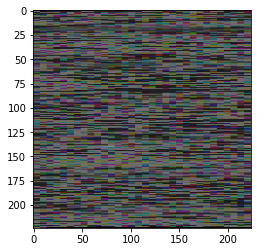

In [43]:
import matplotlib.pyplot as plt
im = image.load_img(filename, target_size=(224,224))
plt.imshow(im)

In [44]:
predict_image(model, filename)

('malware', 0.6496413350105286)

# Database Unit

In [9]:
import sqlite3

import json

conn = sqlite3.connect("MalDet.db")

c = conn.cursor()

# sha = '7f390c85bbfa1de6390618447e4e28d8ff47260118ab4ce31557fdf6e0ee0282b4bb4ab0fbfdcff65955e21de46681b4a634f9cf77e48609d027a296505ec56a'

# c.execute('''CREATE TABLE MalDet_List
# ([generated_id] INTEGER PRIMARY KEY,
# [filename] text, [filetype] text,
# [type_probability] real, [sha_512] text, 
# [analysis_date] text, [analyzer_ip] text)''')

# insert_query = f"""INSERT INTO MalDet_List

#                           (filename, filetype, type_probability, 

#                           sha_512, analysis_date) 

#                            VALUES 

#                           (?,?,?,?,?)"""

# search_query = """SELECT sha_512 FROM MalDet_List WHERE sha_512=?"""

# data_tuple = ('0404b8957c27de20bebb133d3cf0a28e30700f667f7c2f3fe7fde7e726b691cd',

#                           'malware', 0.9144543409347534,

#                           '7f390c85bbfa1de6390618447e4e28d8ff47260118ab4ce31557fdf6e0ee0282b4bb4ab0fbfdcff65955e21de46681b4a634f9cf77e48609d027a296505ec56a',

#                           datetime.now().strftime("%d %B %Y"))

# c.execute(insert_query, data_tuple)

# c.execute(search_query, (sha,))

# c.execute("""SELECT * from MalDet_List

#     where sha_512=?""", (sha,))

# c.execute("""SELECT * from MalDet_List""")

# c.execute("""DELETE from MalDet_List where analysis_date=?""",
#           ('11 February 2021',))
conn.commit()
c.execute("""SELECT * from MalDet_List""")
rows = c.fetchall()
info = dict()
ids = []
names = []
types = []
probabilities = []
sha512 = []
dates = []
ips = []
for row in rows:
    ids.append(row[0])
    names.append(row[1])
    types.append(row[2])
    probabilities.append(row[3])
    sha512.append(row[4])
    dates.append(row[5])
    ips.append(row[6])
    
info['ids'] = ids
info['names'] = names
info['types'] = types
info['probabilities'] = probabilities
info['sha512'] = sha512
info['dates'] = dates
info['ips'] = ips
print(json.dumps(info))
conn.commit()

conn.close()

{"ids": [1, 2, 3, 4, 5, 6], "names": ["save_and_load.ipynb", "classification-checkpoint.ipynb", "text_classification_with_hub.ipynb", "regression.ipynb", "overfit_and_underfit.ipynb", "text_classification.ipynb"], "types": ["malware", "malware", "malware", "malware", "malware", "malware"], "probabilities": [0.649, 0.799, 0.909, 0.92, 0.6, 0.863], "sha512": ["6446f48e54f5c764fca8bb437cdd434d66608955acf6e7b877fc66b30ff8a4be2dc0b0c4958dffb2d7285d572316544b5f50e4f9d2c989f4e7e6e1ad0b0c4415", "0427aaa10ec4aead016ceafaf0407ae0e866b79dcfee54e8a0b1ed2db23228966dd93a8074f3f7dfe8a8532e8a2cd97108ffa617f873e1f9140bb5029de5210c", "b7d7a501b0c23d635e126bb4d6ab8e6cdb19f4b07d34f4642dda3bfa8d687f42b7597d5aec2988b7e696b0df555807d7a3053e26872c53bf5bd8fdcfe7c6b00e", "3497d82787865a1cf2232e9fcc8cecec12016163594c8621ebcf69a1f30f1d2282a2b6b6fc027d1e18c5b486c73ff09b61c2884924d6baa693494729bc21fffd", "e8b545fa4677dd052dc903db75420a9eaa3720f4daf47fe2151b8d71969a9649ddd358442f3aa186603c20bcae67cfcdee9e7b4c66d167f

# Server Unit

In [12]:
from flask import Flask, request, abort, jsonify, send_from_directory
from hashlib import sha512
import re
import base64

UPLOAD_DIRECTORY = "./files"

if not os.path.exists(UPLOAD_DIRECTORY):
    os.makedirs(UPLOAD_DIRECTORY)

def analysis(filename=0,data=0, mode=0, mfl=False,ip=''):
    FLAG=False
    conn = sqlite3.connect("MalDet.db")
    c = conn.cursor()
    if filename and not data:
        with open(os.path.join(UPLOAD_DIRECTORY,filename), 'rb') as f:
            data = f.read()
    sha = sha512(data).hexdigest()
    c.execute("""SELECT sha_512 from MalDet_List
    where sha_512=?""", (sha,))
    rows = c.fetchall()
    if rows:
        FLAG=True
    if FLAG:
        print('existing file, searching...')
        c.execute("""SELECT * from MalDet_List
    where sha_512=?""", (sha,))
        rows = c.fetchall()
        conn.commit()
        conn.close()
        if mode == '2':
            return unit_pack(rows, mode)
        else:
            return unit_pack(rows, mode)
    else:
        print("new file, processing...")
        if mfl:
            filepath = filename
        else:
            filepath = os.path.join(UPLOAD_DIRECTORY, filename)
            with open(filepath, "wb") as fp:
                fp.write(request.data)
        picture = createRGBImage(filepath)
        result = predict_image(model, picture)
        if '/' in filename:
            filename = filename.split('/')[-1]
        data_tuple = (filename,result[0],
                      int(result[1]*1000)/1000,sha,
                      datetime.now().strftime("%d %B %Y"), ip)
        query = """INSERT INTO MalDet_List
                       (filename, filetype, type_probability, 
                       sha_512, analysis_date, analyzer_ip) 
                        VALUES 
                       (?,?,?,?,?,?)"""
        c.execute(query, data_tuple)
        os.remove(filepath)
        os.remove(picture)
        conn.commit()
        conn.close()
        if mode == '2':
            return result
        elif mode == '1':
            info = dict()
            info['name'] = data_tuple[0]
            info['type'] = data_tuple[1]
            info['probability'] = int(data_tuple[2]*1000)/1000
            info['sha512'] = data_tuple[3]
            info['date'] = data_tuple[4]
            info['source_ip'] = data_tuple[5]
            return info
        elif mode == '0':
            info = dict()
            info['name'] = data_tuple[0]
            info['type'] = data_tuple[1]
            return info

def multiple_pack(rows: list, mode: int):
    info = dict()
    names = []
    types = []
    probabilities = []
    sha512 = []
    dates = []
    ips = []
    for row in rows:
        names.append(row[1])
        types.append(row[2])
        probabilities.append(row[3])
        sha512.append(row[4])
        dates.append(row[5])
        ips.append(row[6])
    if mode:
        info['names'] = names
        info['types'] = types
        info['probabilities'] = probabilities
        info['sha512'] = sha512
        info['dates'] = dates
        info['source_ips'] = ips
    else:
        info['names'] = names
        info['types'] = types
    return info

def unit_pack(rows: list, mode: int):
    info = dict()
    name = rows[0][1]
    type_ = rows[0][2]
    probability = rows[0][3]
    sha512 = rows[0][4]
    date = rows[0][5]
    ip = rows[0][6]
    if mode == '1':
        info['name'] = name
        info['type'] = type_
        info['probability'] = probability
        info['sha512'] = sha512
        info['date'] = date
        info['source_ip'] = ip
    else:
        info['name'] = name
        info['type'] = type_
    return info

api = Flask(__name__)


@api.route("/")
def check_response():
    ip = request.headers['IP']+' '
    date = datetime.now().strftime('%H:%M:%S %d/%b/%y')
    cookie = base64.encodebytes((ip+date).encode()).decode().strip()
    return jsonify(cookie)

@api.route("/files")
def list_files():
    conn = sqlite3.connect("MalDet.db")
    c = conn.cursor()
    c.execute("""SELECT filename,analysis_date from MalDet_List""")
    rows = c.fetchall()
    return jsonify(rows)

@api.route("/search/<h>")
def search(h):
    conn = sqlite3.connect("MalDet.db")
    c = conn.cursor()
    rows = []
    missing_message = ''
    if request.headers['search_ip']:
        if re.match('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$', request.headers['search_ip']):
            c.execute("""SELECT * from MalDet_List where analyzer_ip=?""", (request.headers['search_ip'],))
            rows = c.fetchall()
            missing_message = 'such ip address has not analyzed any file yet'
        else:
            return jsonify('invalid ip address')
    elif request.headers['date']:
        if re.match('^(0?[1-9]|[12][0-9]|3[01])[\/\-](0?[1-9]|1[012])[\/\-]\d{4}$', request.headers['date']):
            date_date = datetime.strptime(request.headers['date'], '%d/%m/%Y')
            date = datetime.strftime(date_date, '%d %B %Y')
            c.execute("""SELECT * from MalDet_List where analysis_date=?""", (date,))
            rows = c.fetchall()
            missing_message = 'the system was chilling this day'
        else:
            return jsonify('invalid date format')
    else:
        if re.match('^[a-f0-9]{128}$', h):
            c.execute("""SELECT * from MalDet_List where sha_512=?""", (h,))
            rows = c.fetchall()
            missing_message = 'this file has not been analyzed yet'
        else:
            return jsonify('invalid hash value')
    if rows:
        return jsonify(multiple_pack(rows,mode='1'))
    else:
        return jsonify(missing_message)

# @api.route("/files/<path:path>")
# def get_file(path):
#     """Download a file."""
#     return send_from_directory(UPLOAD_DIRECTORY, path, as_attachment=True)

@api.route("/files/analysis/<mode>", methods=["GET"])
def analysis_from_upload_dir(mode, upload_dir_path=UPLOAD_DIRECTORY):
    analyzed_files = dict()
    files = os.listdir(upload_dir_path)
    for file in files.copy():
        if os.path.isdir(os.path.join(upload_dir_path,file)):
            files.remove(file)
    for file in files:
        print(os.path.join(upload_dir_path,file))
        analyzed_files[file] = analysis(filename=os.path.join(upload_dir_path,file),
                                        mode=mode, mfl=True, ip=request.headers['IP'])
    return jsonify(analyzed_files)
        
        

@api.route("/files/<filename>/<mode>", methods=["POST"])
def post_file(filename, mode):
    """Upload a file."""
    if mode == '3':
        filepath = os.path.join(UPLOAD_DIRECTORY, filename)
        with open(filepath, "wb") as fp:
            fp.write(request.data)
            return jsonify(f'file {filename} uploaded')
    info = analysis(filename=filename, data=request.data, 
                    mode=mode, ip=request.headers['IP'])
    return jsonify(info)

if __name__ == "__main__":
    api.run(host='0.0.0.0',debug=True, port=8003,use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:8003/ (Press CTRL+C to quit)
172.17.0.1 - - [13/Feb/2021 09:58:05] "GET / HTTP/1.1" 200 -


new file, processing...


172.17.0.1 - - [13/Feb/2021 09:58:07] "POST /files/0404b8957c27de20bebb133d3cf0a28e30700f667f7c2f3fe7fde7e726b691cd/1 HTTP/1.1" 200 -
172.17.0.1 - - [13/Feb/2021 09:58:27] "GET / HTTP/1.1" 200 -
172.17.0.1 - - [13/Feb/2021 09:58:27] "POST /files/0404b8957c27de20bebb133d3cf0a28e30700f667f7c2f3fe7fde7e726b691cd/1 HTTP/1.1" 200 -


existing file, searching...


172.17.0.1 - - [13/Feb/2021 10:05:30] "GET / HTTP/1.1" 200 -
172.17.0.1 - - [13/Feb/2021 10:05:30] "POST /files/0404b8957c27de20bebb133d3cf0a28e30700f667f7c2f3fe7fde7e726b691cd/0 HTTP/1.1" 200 -


existing file, searching...


172.17.0.1 - - [13/Feb/2021 10:07:00] "GET / HTTP/1.1" 200 -


new file, processing...


172.17.0.1 - - [13/Feb/2021 10:07:00] "POST /files/Install-Linux-tar.txt/1 HTTP/1.1" 200 -
172.17.0.1 - - [13/Feb/2021 10:15:24] "GET / HTTP/1.1" 200 -
172.17.0.1 - - [13/Feb/2021 10:15:24] "GET /search/123321 HTTP/1.1" 200 -
